In [1]:
# general 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# geography 
import geopandas
import plotly.express as px
from shapely.ops import unary_union
import json

# progress
from tqdm import tqdm
tqdm.pandas()
from IPython.display import HTML

# Data 

DANE sources:

* [GeoJSON download page](https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/visor-descarga-geovisores/)
    * [Municipality level polygons](https://geoportal.dane.gov.co/descargas/CNPV2018/Geojson/GeoJsonMGN_ANM_MPIOS.rar)
* [geographical listings and metadata](https://www.dane.gov.co/files/geoportal-provisional/)
    * [political-administrative division](https://www.dane.gov.co/files/geoportal-provisional/Listados_DIVIPOLA.zip)
    
Both datasets have to be downloaded manually because of DANE's bot protection policy.

This code assumes these files were uncompressed on this folder.

## DANE divipola listing (official name and codes), 2022

In [2]:
xls = pd.ExcelFile("CODIFICACION_DIVIPOLA/Listados_DIVIPOLA.xlsx")
DANE = pd.read_excel(xls,"Municipios",skiprows=11,dtype=str,header=None)
DANE = DANE.loc[:1120]
DANE.drop([0,4,5],axis=1,inplace=True)
DANE.rename(columns={1:"departamento",2:"ID",3:"municipio"},inplace=True)
DANE.set_index("ID",inplace=True)
DANE.head()

,departamento,municipio
ID,,
05001,ANTIOQUIA,MEDELLÍN
05002,ANTIOQUIA,ABEJORRAL
05004,ANTIOQUIA,ABRIAQUÍ
05021,ANTIOQUIA,ALEJANDRÍA
05030,ANTIOQUIA,AMAGÁ


## Official geoJSON, 2018

In [3]:
geo = geopandas.read_file("GeoJsonMGN_ANM_MPIOS/MGN_ANM_MPIOS.geojson")

In [4]:
geo["adjacent"] = ""
# drop STATS columns
geo = geo.drop([col for col in geo.columns if set("ST") <= set(col)],axis=1)
# drop unneded shape columns
geo = geo.drop(["VERSION","Shape_Leng","Shape_Area"],axis=1)

geo = geo.rename(columns={
    'DPTO_CCDGO':"ID_DEP",
    'MPIO_CCDGO':"ID_MUN",
    'MPIO_CNMBR':"municipio",
    'MPIO_CDPMP':"ID"
})

geo.set_index("ID",inplace=True)

In [5]:
geo.head()

,ID_DEP,ID_MUN,municipio,AREA,LATITUD,LONGITUD,geometry,adjacent
ID,,,,,,,,
18001,18,001,FLORENCIA,2.547638e+09,1.749139,-75.558239,"MULTIPOLYGON (((-75.42074 2.19413, -75.42042 2...",
18029,18,029,ALBANIA,4.141221e+08,1.227865,-75.882327,"MULTIPOLYGON (((-75.89506 1.36570, -75.89506 1...",
18094,18,094,BELÉN DE LOS ANDAQUÍES,1.191619e+09,1.500923,-75.875645,"MULTIPOLYGON (((-75.78705 1.74982, -75.78715 1...",
18247,18,247,EL DONCELLO,1.106076e+09,1.791386,-75.193944,"MULTIPOLYGON (((-75.36167 2.32143, -75.36142 2...",
18256,18,256,EL PAUJÍL,1.234734e+09,1.617746,-75.234043,"MULTIPOLYGON (((-75.36638 2.20952, -75.35963 2...",


### Correction (2018->2022)

As the geoJSON is older than the listing, there are some discrepancies:

In [6]:
# all IDs in geo that are not in DANE
set(geo.index) - set(DANE.index)

{'94663'}

In [7]:
# all IDs in DANE that are not in geo
set(DANE.index) - set(geo.index)

set()

The missing one is

In [8]:
geo.loc[["94663"]]

,ID_DEP,ID_MUN,municipio,AREA,LATITUD,LONGITUD,geometry,adjacent
ID,,,,,,,,
94663,94,663,MAPIRIPANA,4.927905e+09,2.808882,-70.269326,"MULTIPOLYGON (((-70.10453 3.38436, -70.10219 3...",


Wich since has merged with `94343`, Barrancominas, Guainía.

<AxesSubplot:>

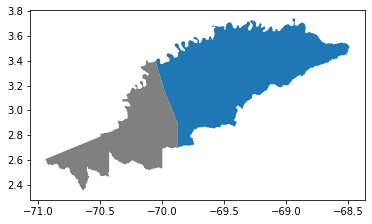

In [9]:
geo.loc[["94663"]].plot(color='gray')
geo.loc[["94343"]].plot(ax=plt.gca())

In [10]:
geo.loc[["94663","94343"]]

,ID_DEP,ID_MUN,municipio,AREA,LATITUD,LONGITUD,geometry,adjacent
ID,,,,,,,,
94663,94,663,MAPIRIPANA,4.927905e+09,2.808882,-70.269326,"MULTIPOLYGON (((-70.10453 3.38436, -70.10219 3...",
94343,94,343,BARRANCOMINAS,9.467772e+09,3.313508,-69.398770,"MULTIPOLYGON (((-68.91332 3.68216, -68.91308 3...",


In [11]:
geo.at["94343","geometry"] = unary_union(geo.loc[["94663","94343"]].geometry)

In [12]:
geo.drop("94663",inplace=True)

<AxesSubplot:>

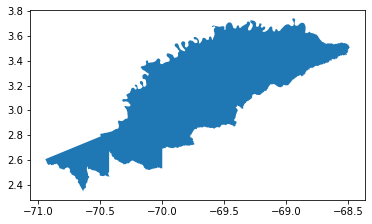

In [13]:
geo.loc[["94343"]].plot()

The IDs are now complete

In [14]:
set(geo.index) == set(DANE.index)

True

### Limiting regions

In [15]:
# add all surroinding municipalities (and itself) to adjacent regions, as a list
for i,mun in tqdm(geo.iterrows(),total=len(geo)):
    geo.at[i,"adjacent"] = [i] + list(
        geo[ geo.geometry.touches(mun.geometry) ].index
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:52<00:00, 21.30it/s]


An example: the first municipality by code (dark) and all its adjacent regions

Text(0.5, 1.0, 'MEDELLÍN')

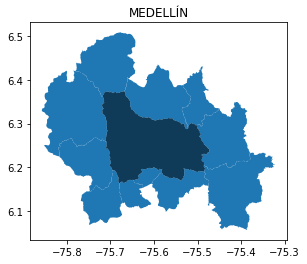

In [16]:
ad = geo.loc[geo.loc['05001'].adjacent].plot(ax=plt.gca())
own = geo.loc[['05001']].plot(ax=plt.gca(),color='k',alpha=0.5)
plt.title(geo.loc['05001',"municipio"])

#### Adjacent municipalities

With this we can construct an adjacent municipalities dictionary, that maps every municipality code to a list with the codes of its limiting municipality (and itself)

In [17]:
adjacent_mun = geo.adjacent.to_dict()
with open("adjacent_municipalities.json","w") as file:
    json.dump(adjacent_mun,file)

#### Adjacent departments

In [72]:
adjacent_dep = geo.groupby("ID_DEP").adjacent\
    .apply(list)\
    .apply(sum,start=[])\
    .apply(lambda x: list(set(i[:2] for i in x)))\
    .to_dict()

with open("adjacent_departments.json","w") as file:
    json.dump(adjacent_dep,file)

#### Municipalities of adjacent departments

In [84]:
with open("muns_of_adjacent_deps.json","w") as file:
    json.dump(
        {dep:geo.query("ID_DEP in @adjacent").index.unique().tolist() for dep,adjacent in adjacent_dep.items()},
        file
    )

# GeoJSON Reduction

Without reducing the geographical data from DANE, plotting would be impossible. The geojson's polygons for the municipality level has an incredible amount of detail.

For the reduction we use the [geopandas simplify function](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.simplify.html):

In [26]:
geo_simple = geo.copy()
%time geo_simple.geometry = geo.geometry.simplify(0.01)

CPU times: user 6.25 s, sys: 6.55 ms, total: 6.26 s
Wall time: 6.27 s


We have reduced the amount of data by two orders of magnitude:

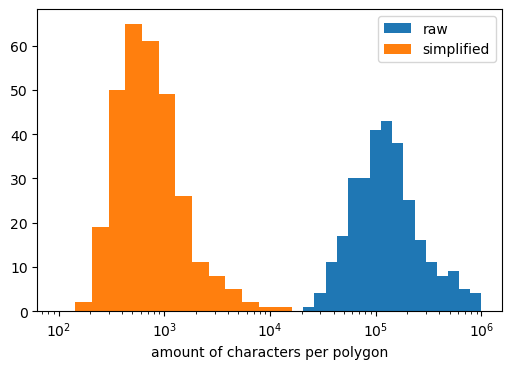

In [27]:
plt.figure(dpi=100)
geo.geometry.sample(300).apply(str).apply(len).hist(bins=np.logspace(4,6,20),ax=plt.gca(),label="raw")
geo_simple.geometry.sample(300).apply(str).apply(len).hist(bins=np.logspace(2,5,20),ax=plt.gca(),label="simplified")
plt.xscale("log")
plt.legend()
plt.xlabel("amount of characters per polygon")
plt.grid(False);

In [29]:
geo_simple = pd.concat([DANE.departamento,geo_simple],axis=1)[[
    "ID_DEP","departamento",
    "ID_MUN","municipio",
    "LATITUD","LONGITUD",
    "adjacent","AREA","geometry"
]]

In [40]:
for column in ["departamento","municipio"]:
    geo_simple[column] = geo_simple[column].str.lower()

In [55]:
# GeoJSON does not support simple arrays, for some reason
geo_simple.adjacent = geo_simple.adjacent.apply(" ".join)

In [54]:
with open("Municipios_Colombia.geojson","w") as file:
    file.write(geo_simple.to_json(drop_id=False))

# Finally

We have dictionaries describing the adjacent municipalities for every municipality and department.

This will allow us to search for a missing municipality name on both the department that is reported an in the limiting municipalities outside the given department.

For example, if the reported department is Cauca, we would search on:

In [33]:
geo_simple.query("departamento == 'CAUCA'").ID_DEP.unique()

array(['19'], dtype=object)

In [34]:
dep = '19'
subset = geo_simple.query("ID_DEP == @dep")

<AxesSubplot:>

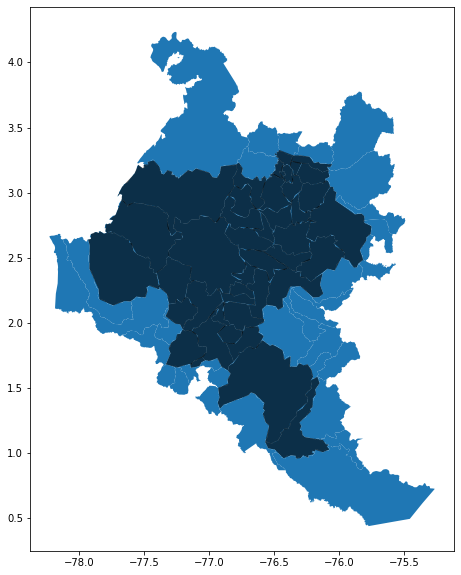

In [35]:
plt.figure(figsize=(10,10))
geo.loc[limit_and_self_mun[dep]].plot(ax=plt.gca())
subset.geometry.plot(ax=plt.gca(),color='k',alpha=0.6)

Where the municipalities of Cauca are in dark blue, and the limiting ones in blue

# Last details

In [49]:
geo_simple

,ID_DEP,departamento,ID_MUN,municipio,LATITUD,LONGITUD,adjacent,AREA,geometry
ID,,,,,,,,,
05001,05,antioquia,001,medellín,6.257590,-75.611031,"[05001, 05088, 05036, 05266, 05240, 05212, 056...",3.748306e+08,"POLYGON ((-75.66974 6.37360, -75.63443 6.31732..."
05002,05,antioquia,002,abejorral,5.803728,-75.438474,"[05002, 17013, 05756, 05679, 05148, 05467, 054...",5.071341e+08,"POLYGON ((-75.46938 5.94575, -75.44551 5.93363..."
05004,05,antioquia,004,abriaquí,6.627569,-76.085978,"[05004, 05042, 05306, 05138, 05125, 05284, 05847]",2.969560e+08,"POLYGON ((-76.08351 6.75050, -76.04027 6.70466..."
05021,05,antioquia,021,alejandría,6.365534,-75.090597,"[05021, 05690, 05206, 05670, 05667, 05321]",1.289322e+08,"POLYGON ((-75.03320 6.41586, -74.98522 6.37545..."
05030,05,antioquia,030,amagá,6.032922,-75.708003,"[05030, 05036, 05861, 05809, 05282, 05129]",8.413248e+07,"POLYGON ((-75.67587 6.08561, -75.67155 6.05480..."
...,...,...,...,...,...,...,...,...,...
97889,97,vaupés,889,yavaraté,0.833312,-69.618678,"[97889, 97001]",4.660406e+09,"POLYGON ((-69.70210 1.10907, -69.70361 1.07638..."
99001,99,vichada,001,puerto carreño,5.836530,-68.141222,"[99001, 99524, 99773]",1.220495e+10,"POLYGON ((-67.80972 6.32432, -67.76177 6.29137..."
99524,99,vichada,524,la primavera,5.521561,-69.610481,"[99524, 99624, 99001, 99773, 85430, 85250, 81220]",1.836290e+10,"POLYGON ((-69.03359 6.21870, -69.01390 6.19287..."


In [47]:
geo_simple[["ID_DEP","departamento"]].set_index("ID_DEP").drop_duplicates()

,departamento
ID_DEP,
05,antioquia
08,atlántico
11,"bogotá, d.c."
13,bolívar
15,boyacá
17,caldas
18,caquetá
19,cauca
20,cesar
